# Analysis code for the paper "B1+ shimming in the cervical spinal cord at 7T"

## Assumed input data:
This code is written with the assumption that, for every subject, the data is organized as:
_Subject_
__RF shim directory (Seven directories per subject)
    GRE scan
    TFL_B1map scan
__MPRAGE directory

## Analysis procedure:

For each subject:
-->For each RF shim directory

---->Analyze GRE scans by:
----->Segment the SC from the GRE scan
----->Extract the signal intensity within this mask from the GRE scans

---->Analyze B1+ maps by:
----->Coregistering the anatomical image of the TFL_B1map scan to the corresponding GRE scan (noshim to noshim, CVred to CVred, etc)
----->Warp the previously created mask to the TFL_B1map space
----->Convert the B1+ maps to nT/V units
----->Extract the B1+ value within the coregistered mask



In [3]:
#Necessary imports and helper function

import os
import re
import json
import subprocess
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from tabulate import tabulate
import nibabel as nib
import pandas as pd



In [4]:
# Helper functions
import os
import fnmatch


def count_visible_subdirectories(folder_path):
    subdirectories = [subdir for subdir in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, subdir)) and not subdir.startswith('.')]
    return len(subdirectories)

def named_subdir(folder_path,name):
    for dir_name in os.listdir(folder_path):
        if dir_name.lower() == name:
            return os.path.join(folder_path, dir_name)
    return None  # If no matching directory is found


# Helper function to find a specific string in a specific location in a  JSON and return the matching nifti filename
def find_matching_nii_json_pairs(directory_path, keyword, keywordlocation):
    nii_filename = []

    for filename in os.listdir(directory_path):
        if filename.endswith(".json"):
            json_file_path = os.path.join(directory_path, filename)
            nii_file_path = os.path.join(directory_path, filename.replace(".json", ".nii.gz"))

            if os.path.exists(nii_file_path):
                with open(json_file_path, 'r') as json_file:
                    data = json.load(json_file)
                    if keywordlocation in data and keyword in data[keywordlocation]:
                        nii_filename.append(nii_file_path)

    if not nii_filename:
        raise ValueError("No matching nii.gz files found.")

    return nii_filename

def fetch_file_via_name(directory_path,expression):
    directory_abspath=os.path.abspath(directory_path)
    files = [os.path.join(directory_abspath, file) for file in os.listdir(directory_abspath) if os.path.isfile(os.path.join(directory_abspath, file)) and not file.startswith('.')]
    filtered_files = [file for file in files if fnmatch.fnmatch(file, expression)]
    return filtered_files
    
# Helper function for subprocesses
def run_subprocess(cmd):
    """Wrapper for ``subprocess.run()`` that enables to input ``cmd`` as a full string (easier for debugging).
    Args:
        cmd (string): full command to be run on the command line
    """
    try:
        subprocess.run(
            cmd.split(' '),
            text=True,
            check=True,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
        )
    except subprocess.CalledProcessError as err:
        print(f"Return code: {err.returncode}")
        print("Output:", err.output)
        raise

def GRE_QA_visualizer(datafile,overlayfile):

    datafile_data=nib.load(datafile)
    datafile_data=datafile_data.get_fdata()
    
    overlayfile_data=nib.load(overlayfile)
    overlayfile_data=overlayfile_data.get_fdata()
    overlayfile_data = np.ma.masked_where(overlayfile_data < 0.3, overlayfile_data)
    
    centralslice=(np.floor(datafile_data.shape[0]/2)).astype(int)
    fig, ax = plt.subplots()
    plt.axis('off')
    img1 = ax.imshow(np.rot90(datafile_data[centralslice,:,:]), cmap=plt.cm.gray)
    ax.imshow(np.rot90(overlayfile_data[centralslice,:,:]), cmap=plt.cm.autumn, interpolation='none', alpha=0.5)
    plt.show()

def create_QA_and_Processing_dirs(indir):
    QAdir=os.path.join(indir,'QA')
    if os.path.isdir(QAdir):
        print('')
    else:
        os.makedirs(QAdir)
    Processingdir=os.path.join(indir,'Processing')
    if os.path.isdir(Processingdir):
        print('')
    else:
        os.makedirs(Processingdir)
    return QAdir, Processingdir

def create_QA_and_Processing_dirs_B1(indir):
    QAdir=os.path.join(indir,'QA_B1')
    if os.path.isdir(QAdir):
        print('The QA directory already exists! Are you rerunnig the script?')
    else:
        os.makedirs(QAdir)
    Processingdir=os.path.join(indir,'Processing_B1')
    if os.path.isdir(Processingdir):
        print('The Processing directory already exists! Are you rerunnig the script?')
    else:
        os.makedirs(Processingdir)
    return QAdir, Processingdir

def create_QA_and_Processing_dirs_MPRAGE(indir):
    QAdir=os.path.join(indir,'QA_MPRAGE')
    if os.path.isdir(QAdir):
        print('')
    else:
        os.makedirs(QAdir)
    Processingdir=os.path.join(indir,'Processing_MPRAGE')
    if os.path.isdir(Processingdir):
        print('The Processing directory already exists! Are you rerunnig the script?')
    else:
        os.makedirs(Processingdir)
    return QAdir, Processingdir

def check_number_of_subdirs(indir,number):
    if not count_visible_subdirectories(indir) ==number:
        print('Unexpected number of subdirectories. Please check your data and rerun!')
        exit()

def check_number_of_GRE_scans_distcorr(filenames):
    if len(filenames)==1 or len(filenames)==2:
        distcorr_filename=filenames[-1] #this is the one with distortion correction
        return distcorr_filename
    else:
        print('Unexpected number of NIFTI files found. Please inspect data and rerun!')
        exit() 

def check_number_of_GRE_scans_nodistcorr(filenames):
    if len(filenames)==1 or len(filenames)==2:
        nodistcorr_filename=filenames[0] #this is the one without distortion correction
        return nodistcorr_filename
    else:
        print('Unexpected number of NIFTI files found. Please inspect data and rerun!')
        exit()

# Extracts the Reference Voltage from a json file
def extract_tx_ref_amp(json_file): #this function will extract the TxRefAmp value of the json file, which is
    # the reference voltage
    with open(json_file, "r") as f:
        data = json.load(f)
        return data.get("TxRefAmp", "N/A")

In [5]:
## Setup for contrast agnostic soft segmentation
## REQUIRES THE USE OF THE VENV_MONAI SET UP BELOW
## Requires the notebook being run with the venv_monai kernel!
#1 Install the necessary tools as described here:
# https://github.com/sct-pipeline/contrast-agnostic-softseg-spinalcord/tree/main/monai
#2, Download the inference dataset (model 2023 09 18 zip) from here:
# https://github.com/sct-pipeline/contrast-agnostic-softseg-spinalcord/releases/tag/v2.0
# And unzip it into a folder
monai_checkpoint='/Users/danielpapp/model_2023-09-18/'

#and create an alias for calling it, otherwise its going to be a lot of typing
monai_command='python /Users/danielpapp/contrast-agnostic-softseg-spinalcord-2.0/monai/run_inference_single_image.py'

# reinstalling requrements, just in case
!pip install -r /Users/danielpapp/contrast-agnostic-softseg-spinalcord-2.0/monai/requirements_inference_cpu.txt

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu


In [6]:
def GRE_segment_monai(subjectpath, indirname):
    #Define the GRE scan directory the GRE scans
    GRE_dir=os.path.join(subjectpath,'GRE_B1')   

    #We start by finding the directory, and creating the subdirectories for processing and QA
    dirname_shimcase=named_subdir(GRE_dir,indirname)
    [QAdir, Processingdir]=create_QA_and_Processing_dirs(dirname_shimcase)
    
    #We fetch the GRE scans and check that there are only one or two (Wih and without distortion correction)
    #Changed to use the one WITHOUT distortion correction, as this will be needed for B1 processing
    GRE_filenames=fetch_file_via_name(dirname_shimcase,'*gre*nii.gz')
    GRE_shimfile_nodistcorr=check_number_of_GRE_scans_nodistcorr(GRE_filenames)
    
    #Sometimes there is a 0 -0 discrepancy between the QFORM and SFORM for MGH data. To fix this, we use the 
    # 'set-qform-to-sfrom' option of sct_image
    run_subprocess(f"sct_image -i {GRE_shimfile_nodistcorr} -set-qform-to-sform")
    
    #We can now segment this file
    run_subprocess(f"{monai_command} --path-img {GRE_shimfile_nodistcorr} --path-out {Processingdir} --chkp-path {monai_checkpoint}")
    
    #And turn the soft segmentation into a hard one, so as to not mix evaluating the segmentation and the RF shimming
    GRE_shim_monaisegfilename=fetch_file_via_name(Processingdir,'*gre*_pred.nii.gz')
    GRE_shim_monaisegfilename=GRE_shim_monaisegfilename[0]
    GRE_shim_monaisegfilename_hard=GRE_shim_monaisegfilename.split('.')[0]+'_hard.nii.gz'
    run_subprocess(f"sct_maths -i {GRE_shim_monaisegfilename} -o {GRE_shim_monaisegfilename_hard} -bin 0.5")
    
    #And then we need to do manual checking
    #And extract the signal intensity    
    #GRE_shim_segfilename=fetch_file_via_name(Processingdir,'*gre*_seg.nii.gz')
    #GRE_shim_segfilename=GRE_shim_segfilename[0]
    #GRE_shim_CSVfile=os.path.join(Processingdir,GRE_shimfile_distcorr.split('/')[-1].split('.')[0]+'_sigint.csv')
    #run_subprocess(f"sct_extract_metric -i {GRE_shimfile_distcorr} -f {GRE_shim_segfilename} -o {GRE_shim_CSVfile} -perslice 1")


In [7]:
def GRE_extract_monai(subjectpath,indirname):
    GRE_dir=os.path.join(subjectpath,'GRE_B1')   

    #We start by finding the directory, and creating the subdirectories for processing and QA
    dirname_shimcase=named_subdir(GRE_dir,indirname)
    [QAdir, Processingdir]=create_QA_and_Processing_dirs(dirname_shimcase)
    
    #We fetch the GRE scans and check that there are only one or two (Wih and without distortion correction)
    #Changed to use the one WITHOUT distortion correction, as this will be needed for B1 processing
    GRE_filenames=fetch_file_via_name(dirname_shimcase,'*gre*nii.gz')
    GRE_shimfile_nodistcorr=check_number_of_GRE_scans_nodistcorr(GRE_filenames)
    
    #And extract the signal intensity
    #Check if there is a corrected file
    if not fetch_file_via_name(Processingdir,'*gre*_pred_corr.nii.gz'):
        GRE_shim_monaisegfilename=fetch_file_via_name(Processingdir,'*gre*_pred_hard.nii.gz')
    else:
        GRE_shim_monaisegfilename=fetch_file_via_name(Processingdir,'*gre*_pred_hard_corr.nii.gz')
    GRE_shim_monaisegfilename=GRE_shim_monaisegfilename[0]
    
    GRE_shim_CSVfile=os.path.join(Processingdir,GRE_shimfile_nodistcorr.split('/')[-1].split('.')[0]+'_sigint.csv')
    run_subprocess(f"sct_extract_metric -i {GRE_shimfile_nodistcorr} -f {GRE_shim_monaisegfilename} -o {GRE_shim_CSVfile} -perslice 1")


    #And extract the signal intensity    
    #GRE_shim_segfilename=fetch_file_via_name(Processingdir,'*gre*_seg.nii.gz')
    #GRE_shim_segfilename=GRE_shim_segfilename[0]
    #GRE_shim_CSVfile=os.path.join(Processingdir,GRE_shimfile_distcorr.split('/')[-1].split('.')[0]+'_sigint.csv')
    #run_subprocess(f"sct_extract_metric -i {GRE_shimfile_distcorr} -f {GRE_shim_segfilename} -o {GRE_shim_CSVfile} -perslice 1")


In [8]:
def B1_map_process_monai(subjectpath,indirname):
    #Define the GRE scan directory the GRE scans
    GRE_dir=os.path.join(subjectpath,'GRE_B1')   

    #We start by finding the directory, and creating the subdirectories for processing and QA
    dirname_shimcase=named_subdir(GRE_dir,indirname)
    [QAdir_B1, Processingdir_B1]=create_QA_and_Processing_dirs_B1(dirname_shimcase)
    [QAdir, Processingdir]=create_QA_and_Processing_dirs(dirname_shimcase)
   
    #Find GRE filenames
    GRE_filenames=fetch_file_via_name(dirname_shimcase,'*gre*nii.gz')
    GRE_shimfile_nodistcorr=check_number_of_GRE_scans_nodistcorr(GRE_filenames)
    
    #We fetch the proper segmentation
    if not fetch_file_via_name(Processingdir,'*gre*_pred_corr.nii.gz'):
        GRE_shim_monaisegfilename=fetch_file_via_name(Processingdir,'*gre*_pred_hard.nii.gz')
    else:
        GRE_shim_monaisegfilename=fetch_file_via_name(Processingdir,'*gre*_pred_hard_corr.nii.gz')
    GRE_shim_monaisegfilename=GRE_shim_monaisegfilename[0]
    
    #Next we find the TFL_B1maps anatomical and flip angle maps
    TFL_anatfile=find_matching_nii_json_pairs(dirname_shimcase, 'anatomical', 'ImageComments')[0]
    TFL_FAfile=find_matching_nii_json_pairs(dirname_shimcase, 'angle map', 'ImageComments')[0]

    #We then convert the flip angle map into a nT/V map
    # Maths from Kyle Gilbert
    #GAMMA = 2.675e8
    #B1eff_mag = (AcquiredFA ./ RequestedFA) .* (pi ./ (GAMMA .* 1e-3 .* VoltageAtSocket)); % [T/V]
    #B1eff_mag = B1eff_mag .* 1e9; % [T/V] to [nT/V]
    # The costants sum up to 130.492, so to convert the B1map to nT/V, it has to be divided by 10 (to get it back into units of FA)
    # then multiplied by 130.492 and divided by the VoltageAtSocket

    TFL_FAfile_nTpV=os.path.join(Processingdir_B1,TFL_FAfile.split('.')[0].split('/')[-1]+'_nTpV.nii.gz')
    TFL_FAfile_jsonfile = TFL_FAfile.replace(".nii.gz", ".json")
    RefVol = extract_tx_ref_amp(TFL_FAfile_jsonfile)
    VoltageAtSocket = RefVol * 10**-0.095
    VoltageAtSocket=np.around(VoltageAtSocket, decimals=2)
    run_subprocess(f"sct_maths -i {TFL_FAfile} -div 10 -o {TFL_FAfile_nTpV}")
    run_subprocess(f"sct_maths -i {TFL_FAfile_nTpV} -div {VoltageAtSocket} -o {TFL_FAfile_nTpV}")
    run_subprocess(f"sct_maths -i {TFL_FAfile_nTpV} -mul 130.492 -o {TFL_FAfile_nTpV}")

    #Then we coreigster the B1map anatomical to the undistcorrected GRE
    warp_anat_2_B1_fname=os.path.join(Processingdir_B1,GRE_shimfile_nodistcorr.split('.')[0].split('/')[-1]+'_warp2B1.nii.gz')
    run_subprocess(f"sct_register_multimodal -i {TFL_anatfile} -d {GRE_shimfile_nodistcorr} -ofolder {Processingdir_B1} -qc {QAdir_B1} -dseg {GRE_shim_monaisegfilename} -owarp {warp_anat_2_B1_fname}")


    #Apply this transformation to the segmentation we just produced
    warped_segname=os.path.join(Processingdir_B1,GRE_shim_monaisegfilename.split('.')[0].split('/')[-1]+'_warped.nii.gz')
    run_subprocess(f"sct_apply_transfo -i {GRE_shim_monaisegfilename} -d {TFL_anatfile} -o {warped_segname} -x nn -w {warp_anat_2_B1_fname}")

    #And finally extact the metric
    TFL_FAfile_nTpV_CSV=(TFL_FAfile_nTpV.split('.')[0]+'_SC.csv')
    run_subprocess(f"sct_extract_metric -i {TFL_FAfile_nTpV} -f {warped_segname} -o {TFL_FAfile_nTpV_CSV} -perslice 1")

In [9]:
def B1_map_grab_nTpV_anat_seg_asdata(subjectpath,indirname):
    #Define the GRE scan directory the GRE scans
    GRE_dir=os.path.join(subjectpath,'GRE_B1')   

    #We start by finding the directory, and creating the subdirectories for processing and QA
    dirname_shimcase=named_subdir(GRE_dir,indirname)
    [QAdir_B1, Processingdir_B1]=create_QA_and_Processing_dirs_B1(dirname_shimcase)
    [QAdir, Processingdir]=create_QA_and_Processing_dirs(dirname_shimcase)
   
    #Find GRE filenames
    GRE_filenames=fetch_file_via_name(dirname_shimcase,'*gre*nii.gz')
    GRE_shimfile_nodistcorr=check_number_of_GRE_scans_nodistcorr(GRE_filenames)
    
    #We fetch the proper segmentation
    if not fetch_file_via_name(Processingdir,'*gre*_pred_corr.nii.gz'):
        GRE_shim_monaisegfilename=fetch_file_via_name(Processingdir,'*gre*_pred_hard.nii.gz')
    else:
        GRE_shim_monaisegfilename=fetch_file_via_name(Processingdir,'*gre*_pred_hard_corr.nii.gz')
    GRE_shim_monaisegfilename=GRE_shim_monaisegfilename[0]
    
    #Next we find the TFL_B1maps anatomical and flip angle maps
    TFL_FAfile=find_matching_nii_json_pairs(dirname_shimcase, 'angle map', 'ImageComments')[0]

    TFL_FAfile_nTpV=os.path.join(Processingdir_B1,TFL_FAfile.split('.')[0].split('/')[-1]+'_nTpV.nii.gz')

    TFL_FAfile_nTpV_CSV=(TFL_FAfile_nTpV.split('.')[0]+'_SC.csv')
    TFL_anatfile=find_matching_nii_json_pairs(dirname_shimcase, 'anatomical', 'ImageComments')[0]
    #returvn as image
    TFL_FAfile_nTpV_image = nib.load(TFL_FAfile_nTpV)
    TFL_anatfile_image = nib.load(TFL_anatfile)
    warped_segname=os.path.join(Processingdir_B1,GRE_shim_monaisegfilename.split('.')[0].split('/')[-1]+'_warped.nii.gz')
    warped_segname_image=nib.load(warped_segname)
    
    return TFL_FAfile_nTpV_image, TFL_anatfile_image, warped_segname_image


In [10]:
def B1map_sigint_reader_with_smoothing_and_cutoff(subjectpath,indirname, smoother, zmin, zmax):
    GRE_dir=os.path.join(subjectpath,'GRE_B1')   
    dirname_shimcase=named_subdir(GRE_dir,indirname)
    [QAdir_B1, Processingdir_B1]=create_QA_and_Processing_dirs_B1(dirname_shimcase)
    [QAdir, Processingdir]=create_QA_and_Processing_dirs(dirname_shimcase)
    
    
    #Fetch filenames
    B1map_CSV=fetch_file_via_name(Processingdir_B1,'*.csv')
 
    B1map_CSVfile=B1map_CSV[0]
    
    dataframe_shimcase=pd.read_csv(B1map_CSVfile, index_col='Slice (I->S)')
    dataframe_shimcase['WA()'] = pd.to_numeric(dataframe_shimcase['WA()'], errors='coerce')
    dataframe_shimcase_vector=dataframe_shimcase['WA()'].to_numpy()
    dataframe_shimcase_vector = np.nan_to_num(dataframe_shimcase_vector, nan=0)

    #Smoothing
    window_size = smoother
    kernel = np.ones(window_size) / window_size
    dataframe_shimcase_vector_smooth = np.convolve(dataframe_shimcase_vector, kernel, mode='valid')

    
    dataframe_shimcase_vector_smooth_cut=dataframe_shimcase_vector_smooth[zmin:zmax]

    
    return dataframe_shimcase_vector_smooth_cut,dataframe_shimcase_vector

In [11]:
def MPRAGE_segment_monai(subjectpath):
    #Define the GRE scan directory the GRE scans
    MPRAGE_dir=os.path.join(subjectpath,'MPRAGE')   

    #We start by finding the directory, and creating the subdirectories for processing and QA
    [QAdir, Processingdir]=create_QA_and_Processing_dirs(MPRAGE_dir)
    
    MPRAGE_filenames_noshim=fetch_file_via_name(MPRAGE_dir,'*mprage*no*nii.gz')
    MPRAGE_shimfile_noshim=check_number_of_GRE_scans_distcorr(MPRAGE_filenames_noshim)

    MPRAGE_filenames_rfshim=fetch_file_via_name(MPRAGE_dir,'*mprage*CV*nii.gz')
    MPRAGE_shimfile_rfshim=check_number_of_GRE_scans_distcorr(MPRAGE_filenames_rfshim)
    
    #Sometimes there is a 0 -0 discrepancy between the QFORM and SFORM for MGH data. To fix this, we use the 
    # 'set-qform-to-sfrom' option of sct_image
    #run_subprocess(f"sct_image -i {MPRAGE_shimfile_distcorr} -set-qform-to-sform")
    
    #We can now segment this files
    run_subprocess(f"{monai_command} --path-img {MPRAGE_shimfile_noshim} --path-out {Processingdir} --chkp-path {monai_checkpoint}")
    run_subprocess(f"{monai_command} --path-img {MPRAGE_shimfile_rfshim} --path-out {Processingdir} --chkp-path {monai_checkpoint}")
    
    #And turn the soft segmentation into a hard one, so as to not mix evaluating the segmentation and the RF shimming
    MPRAGE_shim_monaisegfilename_noshim=fetch_file_via_name(Processingdir,'*mprage*no*_pred.nii.gz')
    MPRAGE_shim_monaisegfilename_noshim=MPRAGE_shim_monaisegfilename_noshim[0]
    MPRAGE_shim_monaisegfilename_hard_noshim=MPRAGE_shim_monaisegfilename_noshim.split('.')[0]+'_hard.nii.gz'
    run_subprocess(f"sct_maths -i {MPRAGE_shim_monaisegfilename_noshim} -o {MPRAGE_shim_monaisegfilename_hard_noshim} -bin 0.5")
    
    #And turn the soft segmentation into a hard one, so as to not mix evaluating the segmentation and the RF shimming
    MPRAGE_shim_monaisegfilename_rfshim=fetch_file_via_name(Processingdir,'*mprage*CV*_pred.nii.gz')
    MPRAGE_shim_monaisegfilename_rfshim=MPRAGE_shim_monaisegfilename_rfshim[0]
    MPRAGE_shim_monaisegfilename_hard_rfshim=MPRAGE_shim_monaisegfilename_rfshim.split('.')[0]+'_hard.nii.gz'
    run_subprocess(f"sct_maths -i {MPRAGE_shim_monaisegfilename_rfshim} -o {MPRAGE_shim_monaisegfilename_hard_rfshim} -bin 0.5")
    
    #And then we need to do manual checking
    #And extract the signal intensity    
    #GRE_shim_segfilename=fetch_file_via_name(Processingdir,'*gre*_seg.nii.gz')
    #GRE_shim_segfilename=GRE_shim_segfilename[0]
    #GRE_shim_CSVfile=os.path.join(Processingdir,GRE_shimfile_distcorr.split('/')[-1].split('.')[0]+'_sigint.csv')
    #run_subprocess(f"sct_extract_metric -i {GRE_shimfile_distcorr} -f {GRE_shim_segfilename} -o {GRE_shim_CSVfile} -perslice 1")


In [12]:
def MPRAGE_extract_monai(subjectpath):
    MPRAGE_dir=os.path.join(subjectpath,'MPRAGE')   

    #We start by finding the directory, and creating the subdirectories for processing and QA
    [QAdir, Processingdir]=create_QA_and_Processing_dirs(MPRAGE_dir)
    
    #Fetch filenames
    MPRAGE_filenames=fetch_file_via_name(MPRAGE_dir,'*mprage*no*nii.gz')
    MPRAGE_shimfile_noshim=check_number_of_GRE_scans_distcorr(MPRAGE_filenames)
    
    MPRAGE_filenames=fetch_file_via_name(MPRAGE_dir,'*mprage*CV*nii.gz')
    MPRAGE_shimfile_rfshim=check_number_of_GRE_scans_distcorr(MPRAGE_filenames)
    #And extract the signal intensity
    #Check if there is a corrected file
    if not fetch_file_via_name(Processingdir,'*mprage*no*_pred_corr.nii.gz'):
        MPRAGE_shim_monaisegfilename_noshim=fetch_file_via_name(Processingdir,'*mprage*no*_pred_hard.nii.gz')
    else:
        MPRAGE_shim_monaisegfilename_noshim=fetch_file_via_name(Processingdir,'*mprage*no*_pred_hard_corr.nii.gz')
    MPRAGE_shim_monaisegfilename_noshim=MPRAGE_shim_monaisegfilename_noshim[0]
    
    if not fetch_file_via_name(Processingdir,'*mprage*CV*_pred_corr.nii.gz'):
        MPRAGE_shim_monaisegfilename_rfshim=fetch_file_via_name(Processingdir,'*mprage*CV*_pred_hard.nii.gz')
    else:
        MPRAGE_shim_monaisegfilename_rfshim=fetch_file_via_name(Processingdir,'*mprage*CV*_pred_hard_corr.nii.gz')
    MPRAGE_shim_monaisegfilename_rfshim=MPRAGE_shim_monaisegfilename_rfshim[0]
    
    MPRAGE_noshim_CSVfile=os.path.join(Processingdir,MPRAGE_shimfile_noshim.split('/')[-1].split('.')[0]+'_sigint.csv')
    run_subprocess(f"sct_extract_metric -i {MPRAGE_shimfile_noshim} -f {MPRAGE_shim_monaisegfilename_noshim} -o {MPRAGE_noshim_CSVfile} -perslice 1")
   
    MPRAGE_rfshim_CSVfile=os.path.join(Processingdir,MPRAGE_shimfile_rfshim.split('/')[-1].split('.')[0]+'_sigint.csv')
    run_subprocess(f"sct_extract_metric -i {MPRAGE_shimfile_rfshim} -f {MPRAGE_shim_monaisegfilename_rfshim} -o {MPRAGE_rfshim_CSVfile} -perslice 1")



In [13]:
def MPRAGE_label_monai(subjectpath):
    #Segmentation is at the moment only used to generate the labels that are then manually used to find C2/C3 and T1/T2
    MPRAGE_dir=os.path.join(subjectpath,'MPRAGE')
     #We start by finding the directory, and creating the subdirectories for processing and QA
    [QAdir, Processingdir]=create_QA_and_Processing_dirs(MPRAGE_dir)
    
    #Fetch filenames
    MPRAGE_filenames=fetch_file_via_name(MPRAGE_dir,'*mprage*no*nii.gz')
    MPRAGE_shimfile_noshim=check_number_of_GRE_scans_distcorr(MPRAGE_filenames)
    
    MPRAGE_filenames=fetch_file_via_name(MPRAGE_dir,'*mprage*CV*nii.gz')
    MPRAGE_shimfile_rfshim=check_number_of_GRE_scans_distcorr(MPRAGE_filenames)
    #And extract the signal intensity
    #Check if there is a corrected file
    if not fetch_file_via_name(Processingdir,'*mprage*no*_pred_corr.nii.gz'):
        MPRAGE_shim_monaisegfilename_noshim=fetch_file_via_name(Processingdir,'*mprage*no*_pred_hard.nii.gz')
    else:
        MPRAGE_shim_monaisegfilename_noshim=fetch_file_via_name(Processingdir,'*mprage*no*_pred_hard_corr.nii.gz')
    MPRAGE_shim_monaisegfilename_noshim=MPRAGE_shim_monaisegfilename_noshim[0]
    
    if not fetch_file_via_name(Processingdir,'*mprage*CV*_pred_corr.nii.gz'):
        MPRAGE_shim_monaisegfilename_rfshim=fetch_file_via_name(Processingdir,'*mprage*CV*_pred_hard.nii.gz')
    else:
        MPRAGE_shim_monaisegfilename_rfshim=fetch_file_via_name(Processingdir,'*mprage*CV*_pred_hard_corr.nii.gz')
    MPRAGE_shim_monaisegfilename_rfshim=MPRAGE_shim_monaisegfilename_rfshim[0]
    
    
    run_subprocess(f"sct_label_vertebrae -i {MPRAGE_shimfile_noshim} -s {MPRAGE_shim_monaisegfilename_noshim} -ofolder {Processingdir} -c t1")
   
    
    run_subprocess(f"sct_label_vertebrae -i {MPRAGE_shimfile_rfshim} -s {MPRAGE_shim_monaisegfilename_rfshim} -ofolder {Processingdir} -c t1")


In [14]:
def MPRAGE_flatten_monai(subjectpath):
    #Segmentation is at the moment only used to generate the labels that are then manually used to find C2/C3 and T1/T2
    MPRAGE_dir=os.path.join(subjectpath,'MPRAGE')
     #We start by finding the directory, and creating the subdirectories for processing and QA
    [QAdir, Processingdir]=create_QA_and_Processing_dirs(MPRAGE_dir)
    
    #Fetch filenames
    MPRAGE_filenames=fetch_file_via_name(MPRAGE_dir,'*mprage*no*nii.gz')
    MPRAGE_shimfile_noshim=check_number_of_GRE_scans_distcorr(MPRAGE_filenames)
    
    MPRAGE_filenames=fetch_file_via_name(MPRAGE_dir,'*mprage*CV*nii.gz')
    MPRAGE_shimfile_rfshim=check_number_of_GRE_scans_distcorr(MPRAGE_filenames)
    #And extract the signal intensity
    #Check if there is a corrected file
    if not fetch_file_via_name(Processingdir,'*mprage*no*_pred_corr.nii.gz'):
        MPRAGE_shim_monaisegfilename_noshim=fetch_file_via_name(Processingdir,'*mprage*no*_pred_hard.nii.gz')
    else:
        MPRAGE_shim_monaisegfilename_noshim=fetch_file_via_name(Processingdir,'*mprage*no*_pred_hard_corr.nii.gz')
    MPRAGE_shim_monaisegfilename_noshim=MPRAGE_shim_monaisegfilename_noshim[0]
    
    if not fetch_file_via_name(Processingdir,'*mprage*CV*_pred_corr.nii.gz'):
        MPRAGE_shim_monaisegfilename_rfshim=fetch_file_via_name(Processingdir,'*mprage*CV*_pred_hard.nii.gz')
    else:
        MPRAGE_shim_monaisegfilename_rfshim=fetch_file_via_name(Processingdir,'*mprage*CV*_pred_hard_corr.nii.gz')
    MPRAGE_shim_monaisegfilename_rfshim=MPRAGE_shim_monaisegfilename_rfshim[0]
    
    run_subprocess(f"sct_flatten_sagittal -i {MPRAGE_shimfile_noshim} -s {MPRAGE_shim_monaisegfilename_noshim}") 
    run_subprocess(f"sct_flatten_sagittal -i {MPRAGE_shimfile_rfshim} -s {MPRAGE_shim_monaisegfilename_rfshim}")
    
    #Fetch filenames and move to Processing directory
    MPRAGE_filenames=fetch_file_via_name(MPRAGE_dir,'*mprage*no*flatten.nii.gz')
    MPRAGE_shimfile_noshim_flatten=check_number_of_GRE_scans_distcorr(MPRAGE_filenames)
    
    MPRAGE_filenames=fetch_file_via_name(MPRAGE_dir,'*mprage*CV*flatten.nii.gz')
    MPRAGE_shimfile_rfshim_flatten=check_number_of_GRE_scans_distcorr(MPRAGE_filenames)
    
    MPRAGE_shimfile_noshim_flatten_move=os.path.join(Processingdir,MPRAGE_shimfile_noshim_flatten.split('/')[-1])
    MPRAGE_shimfile_rfshim_flatten_move=os.path.join(Processingdir,MPRAGE_shimfile_rfshim_flatten.split('/')[-1])

    os.rename(MPRAGE_shimfile_noshim_flatten,MPRAGE_shimfile_noshim_flatten_move)
    os.rename(MPRAGE_shimfile_rfshim_flatten,MPRAGE_shimfile_rfshim_flatten_move)


In [15]:
def MPRAGE_display_monai(subjectpath,vmin,vmax):
    #Here we visualize the two resulting, sagittaly flattened scans next to each other
    MPRAGE_dir=os.path.join(subjectpath,'MPRAGE')
     #We start by finding the directory, and creating the subdirectories for processing and QA
    [QAdir, Processingdir]=create_QA_and_Processing_dirs(MPRAGE_dir)
    
    #Fetch filenames
    MPRAGE_filenames=fetch_file_via_name(Processingdir,'*mprage*no*flatten.nii.gz')
    MPRAGE_shimfile_noshim_flatten=check_number_of_GRE_scans_distcorr(MPRAGE_filenames)
    
    MPRAGE_filenames=fetch_file_via_name(Processingdir,'*mprage*CV*flatten.nii.gz')
    MPRAGE_shimfile_rfshim_flatten=check_number_of_GRE_scans_distcorr(MPRAGE_filenames)
    
    # Load as image 
    noshim_flat_image = nib.load(MPRAGE_shimfile_noshim_flatten)
    rfshim_flat_image = nib.load(MPRAGE_shimfile_rfshim_flatten)
    
    #Manipulations to get just the central portion of the central slice
    
    ymin=(noshim_flat_image.shape[1] // 2)-(noshim_flat_image.shape[1] // 4)
    ymax=(noshim_flat_image.shape[1] // 2)+(noshim_flat_image.shape[1] // 4)
    zmin=0
    zmax=180
    
    noshim_cslice = noshim_flat_image.get_fdata()[ noshim_flat_image.shape[0] // 2, ymin:ymax, zmin:zmax]  
    rfshim_cslice = rfshim_flat_image.get_fdata()[ rfshim_flat_image.shape[0] // 2, ymin:ymax, zmin:zmax]

# Display the central slices side by side
    plt.figure(figsize=(3, 8))
    #vmin = -1  
    #vmax = -0.8

    plt.subplot(1, 2, 1)
    plt.imshow(noshim_cslice.T, cmap='gray', origin='lower',vmin=vmin,vmax=vmax)  
    plt.title('CP mode',color='blue')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(rfshim_cslice.T, cmap='gray', origin='lower',vmin=vmin, vmax=vmax)
    plt.title('CoV reduction',color='orange')
    plt.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.show()
    
    

In [16]:
def MPRAGE_sigint_reader_with_smoothing_and_cutoff(subjectpath, smoother, zmin, zmax):
    #Here we visualize the two resulting, sagittaly flattened scans next to each other
    MPRAGE_dir=os.path.join(subjectpath,'MPRAGE')
     #We start by finding the directory, and creating the subdirectories for processing and QA
    [QAdir, Processingdir]=create_QA_and_Processing_dirs(MPRAGE_dir)
    
    #Fetch filenames
    MPRAGE_filenames=fetch_file_via_name(Processingdir,'*mprage*no*.csv')
    MPRAGE_noshim_csvfile=check_number_of_GRE_scans_distcorr(MPRAGE_filenames)
    
    MPRAGE_filenames=fetch_file_via_name(Processingdir,'*mprage*CV*.csv')
    MPRAGE_rfshim_csvfile=check_number_of_GRE_scans_distcorr(MPRAGE_filenames)
    
    dataframe_noshim=pd.read_csv(MPRAGE_noshim_csvfile, index_col='Slice (I->S)')
    dataframe_noshim['WA()'] = pd.to_numeric(dataframe_noshim['WA()'], errors='coerce')
    dataframe_noshim_vector=dataframe_noshim['WA()'].to_numpy()
    dataframe_noshim_vector = np.nan_to_num(dataframe_noshim_vector, nan=0)

    dataframe_rfshim=pd.read_csv(MPRAGE_rfshim_csvfile, index_col='Slice (I->S)')
    dataframe_rfshim['WA()'] = pd.to_numeric(dataframe_rfshim['WA()'], errors='coerce')
    dataframe_rfshim_vector=dataframe_rfshim['WA()'].to_numpy()
    dataframe_rfshim_vector = np.nan_to_num(dataframe_rfshim_vector, nan=0)
    #Smoothing
    window_size = smoother
    kernel = np.ones(window_size) / window_size
    noshim_sigint_smooth = np.convolve(dataframe_noshim_vector, kernel, mode='valid')
    rfshim_sigint_smooth = np.convolve(dataframe_rfshim_vector, kernel, mode='valid')
    
    noshim_sigint_smooth_cut=noshim_sigint_smooth[zmin:zmax]
    rfshim_sigint_smooth_cut=rfshim_sigint_smooth[zmin:zmax]
    
    return noshim_sigint_smooth_cut,rfshim_sigint_smooth_cut,dataframe_noshim_vector,dataframe_rfshim_vector

In [17]:
##MPRAGE BLOCK

In [ ]:
# Running MONAI MPRAGE segmentation subject by subject 
subjectpath='/Users/danielpapp/DATA/RF_shimming_project_monai/SubE'
MPRAGE_segment_monai(subjectpath)

In [20]:
# Running MONAI MPRAGE label and extraction subject by subject 
subjectpath='/Users/danielpapp/DATA/RF_shimming_project_monai/SubE'
MPRAGE_label_monai(subjectpath)
MPRAGE_extract_monai(subjectpath)

The QA directory already exists! Are you rerunnig the script?
The Processing directory already exists! Are you rerunnig the script?
The QA directory already exists! Are you rerunnig the script?
The Processing directory already exists! Are you rerunnig the script?


In [24]:
#Running MONAI MPRAGE sagittal flattening subject by subject
subjectpath='/Users/danielpapp/DATA/RF_shimming_project_monai/SubD'
MPRAGE_flatten_monai(subjectpath)



The QA directory already exists! Are you rerunnig the script?
The Processing directory already exists! Are you rerunnig the script?


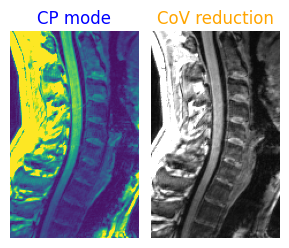









Subject A 27.37 22.07




Subject B 37.83 26.19




Subject C 18.85 16.72




Subject D 19.2 20.47




Subject E 23.41 18.32


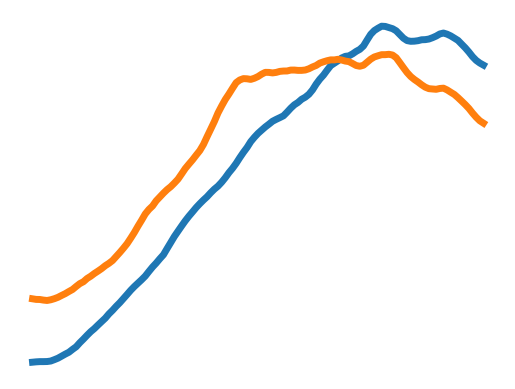

In [126]:
## MPRAGE plotting and visualisation block:

#Here, we only use the labels to find the first and last slice that coresponds to the appropriate boundaries.
#These have to be manually added to the Value Extractor function
subjectpath='/Users/danielpapp/DATA/RF_shimming_project_monai/SubB'
MPRAGE_display_monai(subjectpath, -1, -0.85)

#Plotting signal intensity
noshim_sigint_smooth_cut=MPRAGE_sigint_reader_with_smoothing_and_cutoff(subjectpath,9,15,140)[0] #T2/T3 to C2/C3
rfshim_sigint_smooth_cut=MPRAGE_sigint_reader_with_smoothing_and_cutoff(subjectpath,9,15,140)[1] #T2/T3 to C2/C3
plt.plot(noshim_sigint_smooth_cut, linewidth=5);
plt.plot(rfshim_sigint_smooth_cut, linewidth=5);
plt.axis('off');


#CoV calculation WITHOUT SMOOTHING (but only between C2/C3 and T2/T3)
#SubA
subjectpath='/Users/danielpapp/DATA/RF_shimming_project_monai/SubA'
noshim_sigint_A=MPRAGE_sigint_reader_with_smoothing_and_cutoff(subjectpath,9,19,138)[2]
rfshim_sigint_A=MPRAGE_sigint_reader_with_smoothing_and_cutoff(subjectpath,9,19,138)[3] 
noshim_sigint_A=noshim_sigint_A[19:138]
rfshim_sigint_A=rfshim_sigint_A[19:138]
noshim_sigint_A_COV=np.round(((np.std(noshim_sigint_A))/np.mean(noshim_sigint_A))*100,2)
rfshim_sigint_A_COV=np.round(((np.std(rfshim_sigint_A))/np.mean(rfshim_sigint_A))*100,2)
print('Subject A', noshim_sigint_A_COV, rfshim_sigint_A_COV)
#SubB
subjectpath='/Users/danielpapp/DATA/RF_shimming_project_monai/SubB'
noshim_sigint_B=MPRAGE_sigint_reader_with_smoothing_and_cutoff(subjectpath,9,15,140)[2]
rfshim_sigint_B=MPRAGE_sigint_reader_with_smoothing_and_cutoff(subjectpath,9,15,140)[3] 
noshim_sigint_B=noshim_sigint_B[15:140]
rfshim_sigint_B=rfshim_sigint_B[15:140]
noshim_sigint_B_COV=np.round(((np.std(noshim_sigint_B))/np.mean(noshim_sigint_B))*100,2)
rfshim_sigint_B_COV=np.round(((np.std(rfshim_sigint_B))/np.mean(rfshim_sigint_B))*100,2)
print('Subject B', noshim_sigint_B_COV, rfshim_sigint_B_COV)
#SubC
subjectpath='/Users/danielpapp/DATA/RF_shimming_project_monai/SubC'
noshim_sigint_C=MPRAGE_sigint_reader_with_smoothing_and_cutoff(subjectpath,9,35,140)[2]
rfshim_sigint_C=MPRAGE_sigint_reader_with_smoothing_and_cutoff(subjectpath,9,35,140)[3] 
noshim_sigint_C=noshim_sigint_C[35:140]
rfshim_sigint_C=rfshim_sigint_C[35:140]
noshim_sigint_C_COV=np.round(((np.std(noshim_sigint_C))/np.mean(noshim_sigint_C))*100,2)
rfshim_sigint_C_COV=np.round(((np.std(rfshim_sigint_C))/np.mean(rfshim_sigint_C))*100,2)
print('Subject C', noshim_sigint_C_COV, rfshim_sigint_C_COV)
#SubD
subjectpath='/Users/danielpapp/DATA/RF_shimming_project_monai/SubD'
noshim_sigint_D=MPRAGE_sigint_reader_with_smoothing_and_cutoff(subjectpath,9,48,168)[2]
rfshim_sigint_D=MPRAGE_sigint_reader_with_smoothing_and_cutoff(subjectpath,9,48,168)[3] 
noshim_sigint_D=noshim_sigint_D[48:168]
rfshim_sigint_D=rfshim_sigint_D[48:168]
noshim_sigint_D_COV=np.round(((np.std(noshim_sigint_D))/np.mean(noshim_sigint_D))*100,2)
rfshim_sigint_D_COV=np.round(((np.std(rfshim_sigint_D))/np.mean(rfshim_sigint_D))*100,2)
print('Subject D', noshim_sigint_D_COV, rfshim_sigint_D_COV)
#SubE
subjectpath='/Users/danielpapp/DATA/RF_shimming_project_monai/SubE'
noshim_sigint_E=MPRAGE_sigint_reader_with_smoothing_and_cutoff(subjectpath,9,50,170)[2]
rfshim_sigint_E=MPRAGE_sigint_reader_with_smoothing_and_cutoff(subjectpath,9,50,170)[3] 
noshim_sigint_E=noshim_sigint_E[50:170]
rfshim_sigint_E=rfshim_sigint_E[50:170]
noshim_sigint_E_COV=np.round(((np.std(noshim_sigint_E))/np.mean(noshim_sigint_E))*100,2)
rfshim_sigint_E_COV=np.round(((np.std(rfshim_sigint_E))/np.mean(rfshim_sigint_E))*100,2)
print('Subject E', noshim_sigint_E_COV, rfshim_sigint_E_COV)

The QA directory already exists! Are you rerunnig the script?
The Processing directory already exists! Are you rerunnig the script?


The QA directory already exists! Are you rerunnig the script?
The Processing directory already exists! Are you rerunnig the script?


The QA directory already exists! Are you rerunnig the script?
The Processing directory already exists! Are you rerunnig the script?


The QA directory already exists! Are you rerunnig the script?
The Processing directory already exists! Are you rerunnig the script?


The QA directory already exists! Are you rerunnig the script?
The Processing directory already exists! Are you rerunnig the script?


The QA directory already exists! Are you rerunnig the script?
The Processing directory already exists! Are you rerunnig the script?


The QA directory already exists! Are you rerunnig the script?
The Processing directory already exists! Are you rerunnig the script?




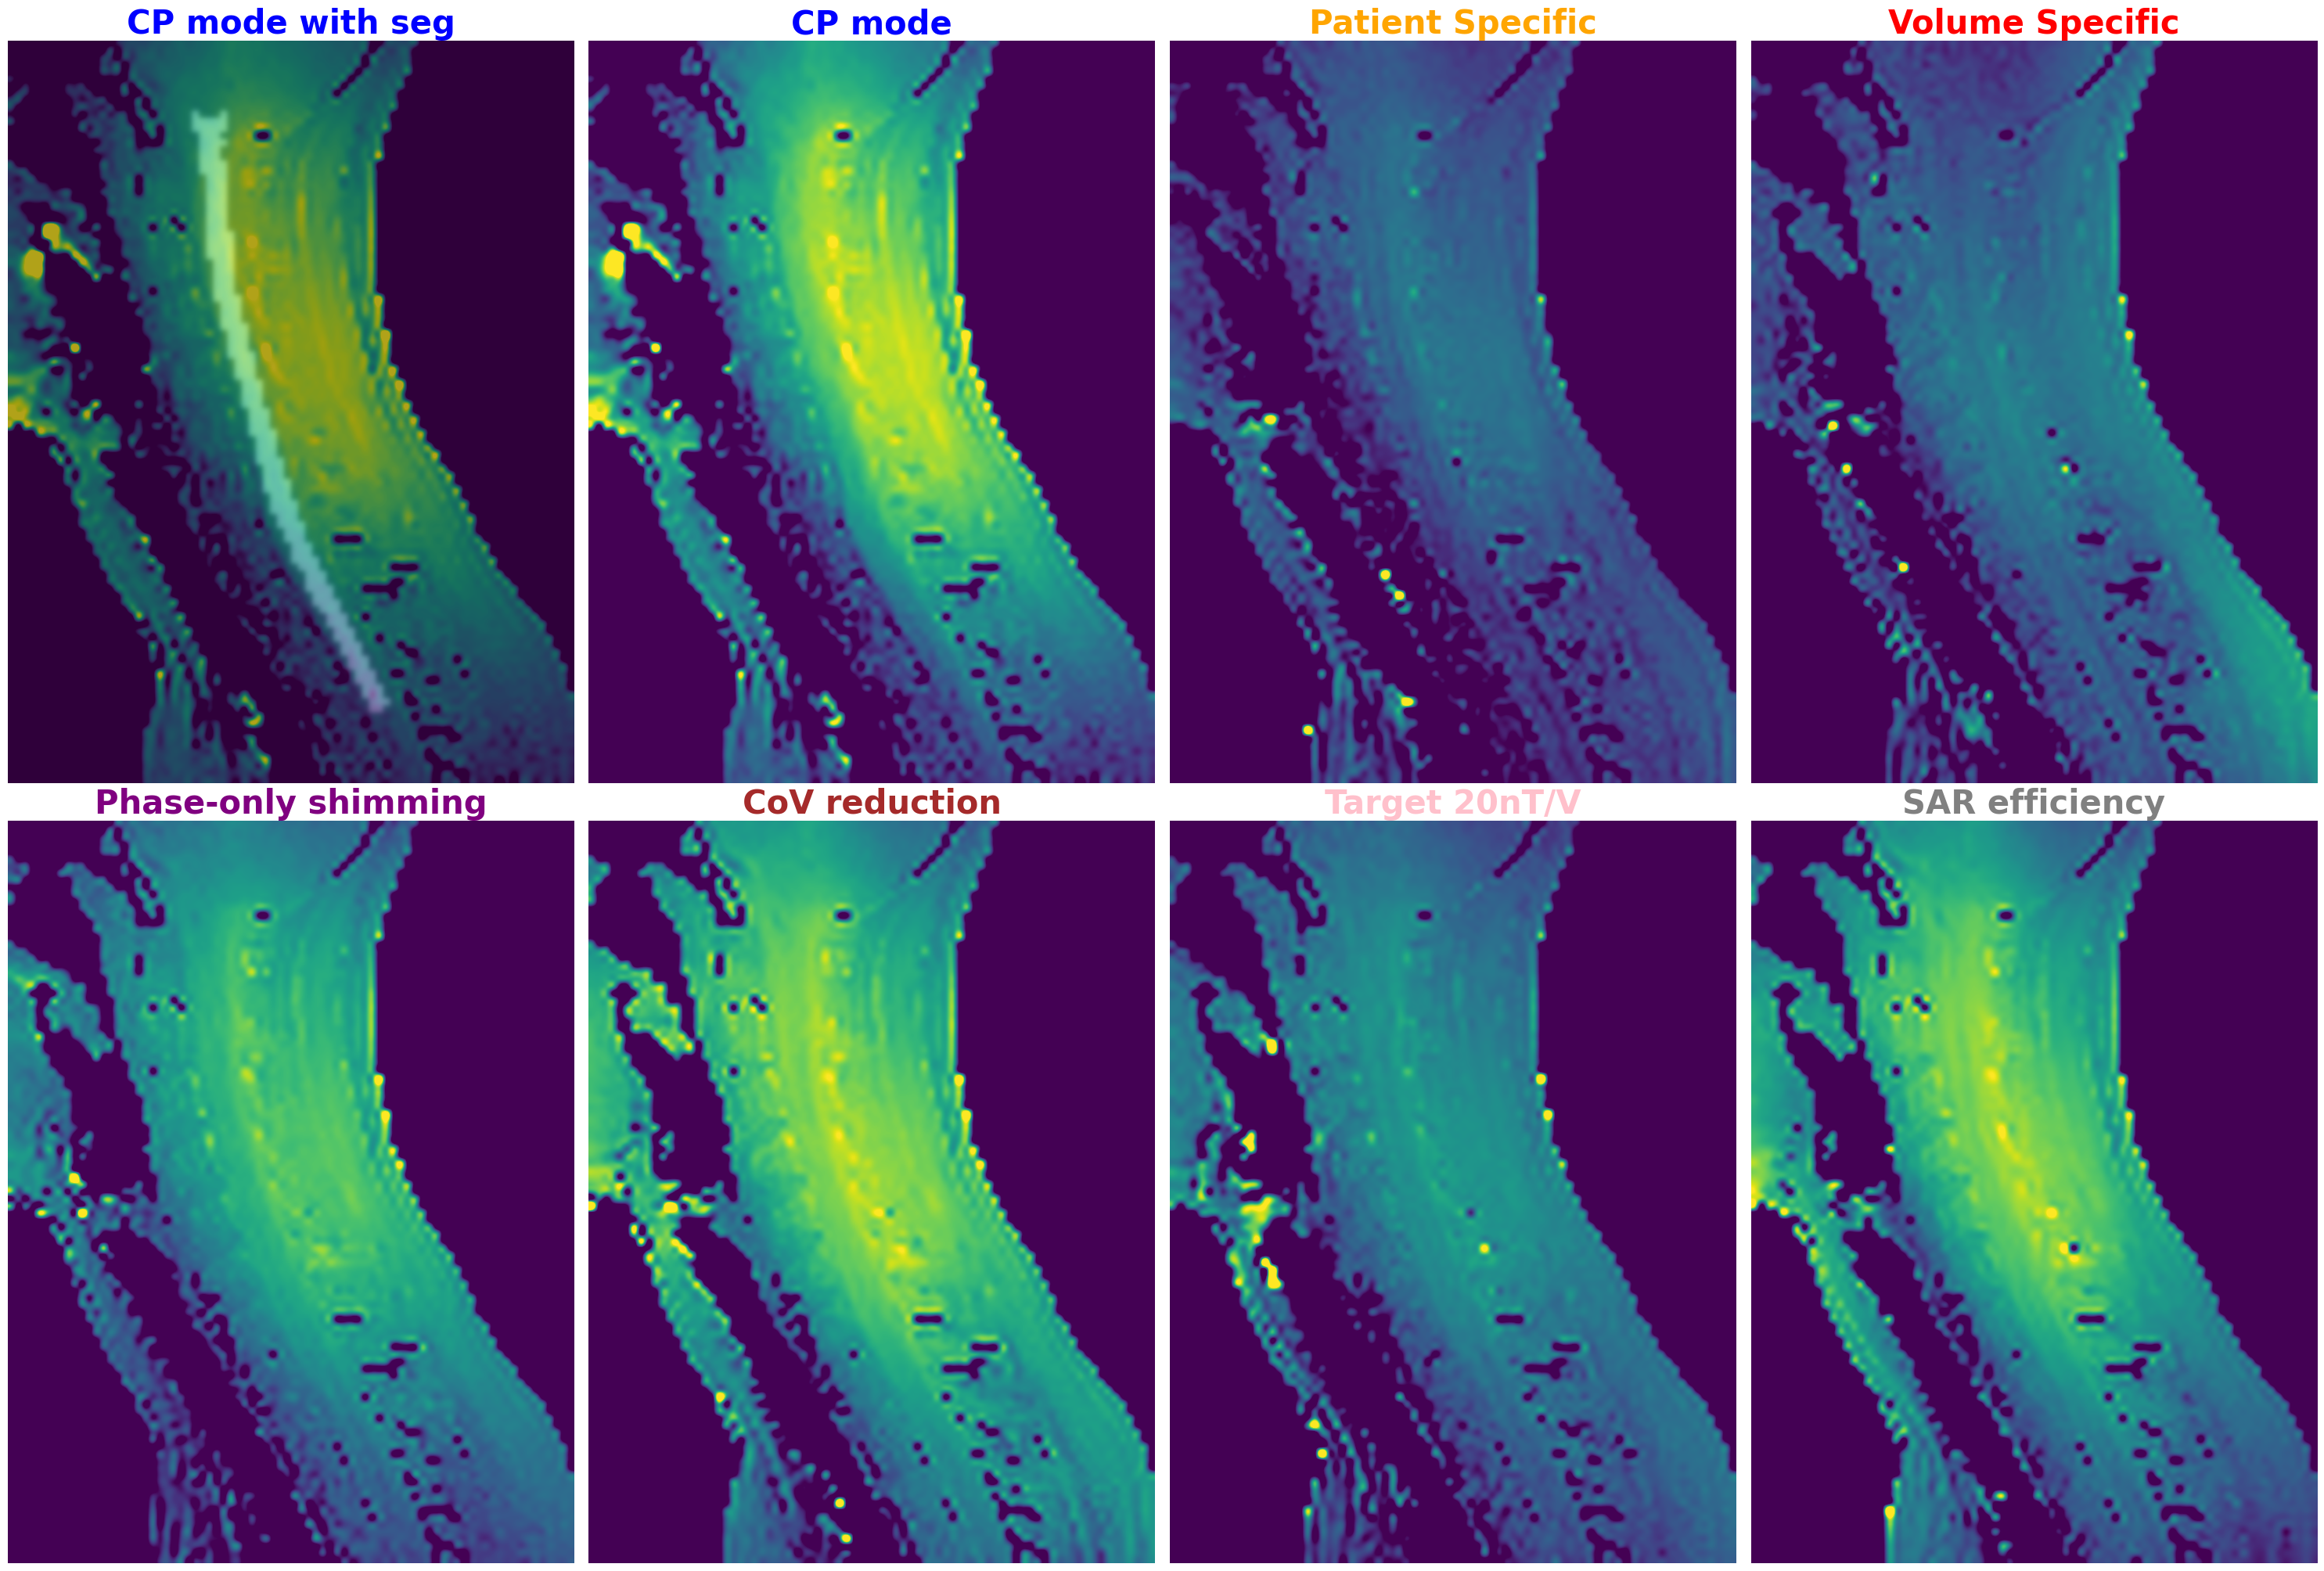

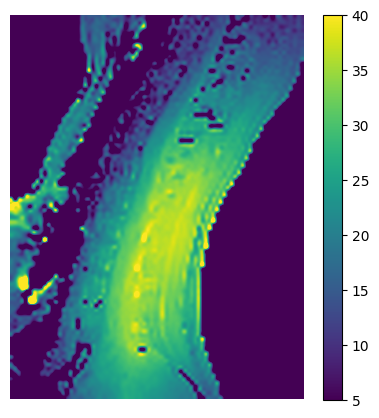

In [32]:
## B1+ visualisation block for figure 2

#Mostly scripted

#Can be very slow

subjectpath='/Users/danielpapp/DATA/RF_shimming_project_monai/SubA'
shimcasenames=['noshim','noshim','patspec','volspec','phaseonly','cvred','target','sareff'] #adding another noshim so I can fill out an 2x4 plot with overlay

[noshim_B1,noshim_anat,noshim_seg]=B1_map_grab_nTpV_anat_seg_asdata(subjectpath,'noshim')
[patspec_B1,patspec_anat,patspec_seg]=B1_map_grab_nTpV_anat_seg_asdata(subjectpath,'patspec')
[volspec_B1,volspec_anat,volspec_seg]=B1_map_grab_nTpV_anat_seg_asdata(subjectpath,'volspec')
[phaseonly_B1,phaseonly_anat,phaseonly_seg]=B1_map_grab_nTpV_anat_seg_asdata(subjectpath,'phaseonly')
[cvred_B1,cvred_anat,cvred_seg]=B1_map_grab_nTpV_anat_seg_asdata(subjectpath,'cvred')
[target_B1,target_anat,target_seg]=B1_map_grab_nTpV_anat_seg_asdata(subjectpath,'target')
[sareff_B1,sareff_anat,sareff_seg]=B1_map_grab_nTpV_anat_seg_asdata(subjectpath,'sareff')


noshim_seg_cslice=noshim_seg.get_fdata()[25:105,35:140, noshim_B1.shape[2] // 2] 
noshim_B1_cslice=noshim_B1.get_fdata()[25:105,35:140, noshim_B1.shape[2] // 2]  
patspec_B1_cslice=patspec_B1.get_fdata()[25:105,35:140, noshim_B1.shape[2] // 2] 
volspec_B1_cslice=volspec_B1.get_fdata()[25:105,35:140, noshim_B1.shape[2] // 2] 
phaseonly_B1_cslice=phaseonly_B1.get_fdata()[25:105,35:140, noshim_B1.shape[2] // 2] 
cvred_B1_cslice=cvred_B1.get_fdata()[25:105,35:140, noshim_B1.shape[2] // 2] 
target_B1_cslice=target_B1.get_fdata()[25:105,35:140, noshim_B1.shape[2] // 2] 
sareff_B1_cslice=sareff_B1.get_fdata()[25:105,35:140, noshim_B1.shape[2] // 2] 

noshim_anat_cslice=noshim_anat.get_fdata()[25:105,35:140, noshim_anat.shape[2] // 2] 

#Masking with anatomical
threshold = 300
mask = np.where(noshim_anat_cslice > threshold, 1, 0)

noshim_B1_cslice_masked=noshim_B1_cslice*mask
patspec_B1_cslice_masked=patspec_B1_cslice*mask
volspec_B1_cslice_masked=volspec_B1_cslice*mask

phaseonly_B1_cslice_masked=phaseonly_B1_cslice*mask
cvred_B1_cslice_masked=cvred_B1_cslice*mask
target_B1_cslice_masked=target_B1_cslice*mask
sareff_B1_cslice_masked=sareff_B1_cslice*mask



plt.figure(figsize=(30, 20))
    #vmin = -1  
    #vmax = -0.8

plt.subplot(2, 4, 1)
plt.imshow(np.flipud(noshim_B1_cslice_masked.T), cmap='viridis', origin='lower',vmin=5,vmax=40, interpolation='spline36')
plt.imshow(np.flipud(noshim_seg_cslice.T), cmap='gray', interpolation='gaussian', alpha=0.3,vmin=0,vmax=1)
plt.title('CP mode with seg',color='blue',fontsize = 30,weight='bold')
plt.axis('off')
plt.subplot(2, 4, 2)
plt.imshow(noshim_B1_cslice_masked.T, cmap='viridis', origin='lower',vmin=5,vmax=40, interpolation='spline36')
plt.title('CP mode',color='blue',fontsize = 30,weight='bold')
plt.axis('off')
plt.subplot(2, 4, 3)
plt.imshow(patspec_B1_cslice_masked.T, cmap='viridis', origin='lower',vmin=5,vmax=40, interpolation='spline36')
plt.title('Patient Specific',color='orange',fontsize = 30,weight='bold')
plt.axis('off')
plt.subplot(2, 4, 4)
plt.imshow(volspec_B1_cslice_masked.T, cmap='viridis', origin='lower',vmin=5,vmax=40, interpolation='spline36')
plt.title('Volume Specific',color='red',fontsize = 30,weight='bold')
plt.axis('off')
plt.subplot(2, 4, 5)
plt.imshow(phaseonly_B1_cslice_masked.T, cmap='viridis', origin='lower',vmin=5,vmax=40, interpolation='spline36')
plt.title('Phase-only shimming',color='purple',fontsize = 30,weight='bold')
plt.axis('off')
plt.subplot(2, 4, 6)
plt.imshow(cvred_B1_cslice_masked.T, cmap='viridis', origin='lower',vmin=5,vmax=40, interpolation='spline36')
plt.title('CoV reduction',color='brown',fontsize = 30,weight='bold')
plt.axis('off')
plt.subplot(2, 4, 7)
plt.imshow(target_B1_cslice_masked.T, cmap='viridis', origin='lower',vmin=5,vmax=40, interpolation='spline36')
plt.title('Target 20nT/V',color='pink',fontsize = 30,weight='bold')
plt.axis('off')
plt.subplot(2, 4, 8)
plt.imshow(sareff_B1_cslice_masked.T, cmap='viridis', origin='lower',vmin=5,vmax=40, interpolation='spline36')
plt.title('SAR efficiency',color='gray',fontsize = 30,weight='bold')
plt.axis('off')

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.05)


plt.figure(figsize=(5, 5))
plt.subplot(1, 1, 1)
plt.imshow(np.flipud(noshim_B1_cslice_masked.T), cmap='viridis', origin='lower',vmin=5,vmax=40, interpolation='spline36')
#plt.title('CP mode with seg',color='blue',fontsize = 30,weight='bold')
plt.axis('off')
plt.colorbar();   




In [31]:
subjectpath='/Users/danielpapp/DATA/RF_shimming_project_monai/SubA' #50-105
shimcasenames=['noshim','noshim','patspec','volspec','phaseonly','cvred','target','sareff'] #adding another noshim so I can fill out an 2x4 plot with overlay

#Calculating mean B1+ efficiency and CoV between C2/C3 and T2/T3
noshim_B1_vector=B1map_sigint_reader_with_smoothing_and_cutoff(subjectpath,'noshim',9,0,50)[1]
patspec_B1_vector=B1map_sigint_reader_with_smoothing_and_cutoff(subjectpath,'patspec',9,0,50)[1]
volspec_B1_vector=B1map_sigint_reader_with_smoothing_and_cutoff(subjectpath,'volspec',9,0,50)[1]

phaseonly_B1_vector=B1map_sigint_reader_with_smoothing_and_cutoff(subjectpath,'phaseonly',9,0,50)[1]
cvred_B1_vector=B1map_sigint_reader_with_smoothing_and_cutoff(subjectpath,'cvred',9,0,50)[1]
target_B1_vector=B1map_sigint_reader_with_smoothing_and_cutoff(subjectpath,'target',9,0,50)[1]
sareff_B1_vector=B1map_sigint_reader_with_smoothing_and_cutoff(subjectpath,'sareff',9,0,50)[1]

#Restricting between 50 and 105 
noshim_B1_vector=noshim_B1_vector[50:105]
patspec_B1_vector=patspec_B1_vector[50:105]
volspec_B1_vector=volspec_B1_vector[50:105]
phaseonly_B1_vector=phaseonly_B1_vector[50:105]
cvred_B1_vector=cvred_B1_vector[50:105]
target_B1_vector=target_B1_vector[50:105]
sareff_B1_vector=sareff_B1_vector[50:105]

noshim_B1_vector_mean=np.round(np.mean(noshim_B1_vector),2)
noshim_B1_vector_CoV=np.round((np.std(noshim_B1_vector)/np.mean(noshim_B1_vector))*100,2)
print('Noshim',noshim_B1_vector_mean,noshim_B1_vector_CoV)

patspec_B1_vector_mean=np.round(np.mean(patspec_B1_vector),2)
patspec_B1_vector_CoV=np.round((np.std(patspec_B1_vector)/np.mean(patspec_B1_vector))*100,2)
print('patspec',patspec_B1_vector_mean,patspec_B1_vector_CoV)

volspec_B1_vector_mean=np.round(np.mean(volspec_B1_vector),2)
volspec_B1_vector_CoV=np.round((np.std(volspec_B1_vector)/np.mean(volspec_B1_vector))*100,2)
print('volspec',volspec_B1_vector_mean,volspec_B1_vector_CoV)

phaseonly_B1_vector_mean=np.round(np.mean(phaseonly_B1_vector),2)
phaseonly_B1_vector_CoV=np.round((np.std(phaseonly_B1_vector)/np.mean(phaseonly_B1_vector))*100,2)
print('phaseonly',phaseonly_B1_vector_mean,phaseonly_B1_vector_CoV)

cvred_B1_vector_mean=np.round(np.mean(cvred_B1_vector),2)
cvred_B1_vector_CoV=np.round((np.std(cvred_B1_vector)/np.mean(cvred_B1_vector))*100,2)
print('CVred',cvred_B1_vector_mean,cvred_B1_vector_CoV)

target_B1_vector_mean=np.round(np.mean(target_B1_vector),2)
target_B1_vector_CoV=np.round((np.std(target_B1_vector)/np.mean(target_B1_vector))*100,2)
print('target',target_B1_vector_mean,target_B1_vector_CoV)

sareff_B1_vector_mean=np.round(np.mean(sareff_B1_vector),2)
sareff_B1_vector_CoV=np.round((np.std(sareff_B1_vector)/np.mean(sareff_B1_vector))*100,2)
print('sareff',sareff_B1_vector_mean,sareff_B1_vector_CoV)

The QA directory already exists! Are you rerunnig the script?
The Processing directory already exists! Are you rerunnig the script?


The QA directory already exists! Are you rerunnig the script?
The Processing directory already exists! Are you rerunnig the script?


The QA directory already exists! Are you rerunnig the script?
The Processing directory already exists! Are you rerunnig the script?


The QA directory already exists! Are you rerunnig the script?
The Processing directory already exists! Are you rerunnig the script?


The QA directory already exists! Are you rerunnig the script?
The Processing directory already exists! Are you rerunnig the script?


The QA directory already exists! Are you rerunnig the script?
The Processing directory already exists! Are you rerunnig the script?


The QA directory already exists! Are you rerunnig the script?
The Processing directory already exists! Are you rerunnig the script?


Noshim 25.33 19.95
patspec 13.4 18.36
volspec 17.31 9.34
phase